## MyanimeList Dataset Analysis for content and collaborative recommendation

In [1]:
import pandas as pd
import sys
import itertools
import numpy as np
import collections
import seaborn as sns
import math
import sklearn
from PIL import Image
import requests
import time
from io import BytesIO
from collections import defaultdict
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import norm
from scipy import sparse
import pickle
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
seed=0
#set print options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=sys.maxsize)

In [2]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Load Datasets

In [3]:
anime = pd.read_csv('./dataset/anime_cleaned.csv')
anime[["score"]]=anime[["score"]]-np.mean(anime[["score"]])
display(anime.head(3))

anime_id               title              title_english title_japanese  \
0     11013       Inu x Boku SS  Inu X Boku Secret Service         妖狐×僕SS   
1      2104    Seto no Hanayome      My Bride is a Mermaid          瀬戸の花嫁   
2      5262  Shugo Chara!! Doki         Shugo Chara!! Doki    しゅごキャラ！！どきっ   

                                  title_synonyms  \
0                                Youko x Boku SS   
1                           The Inland Sea Bride   
2  Shugo Chara Ninenme, Shugo Chara! Second Year   

                                           image_url type source  episodes  \
0  https://myanimelist.cdn-dena.com/images/anime/...   TV  Manga        12   
1  https://myanimelist.cdn-dena.com/images/anime/...   TV  Manga        26   
2  https://myanimelist.cdn-dena.com/images/anime/...   TV  Manga        51   

            status  airing                  aired_string  \
0  Finished Airing   False  Jan 13, 2012 to Mar 30, 2012   
1  Finished Airing   False    Apr 2, 2007 to Oct 1, 2007   
2  Finished Airing   False   Oct 4, 2008 to Sep 25, 2009   

                                        aired         duration  \
0  {'from': '2012-01-13', 'to': '2012-03-30'}  24 min. per ep.   
1  {'from': '2007-04-02', 'to': '2007-10-01'}  24 min. per ep.   
2  {'from': '2008-10-04', 'to': '2009-09-25'}  24 min. per ep.   

                      rating     score  scored_by    rank  popularity  \
0  PG-13 - Teens 13 or older  0.781002     139250  1274.0         231   
1  PG-13 - Teens 13 or older  1.041002      91206   727.0         366   
2              PG - Children  0.701002      37129  1508.0        1173   

   members  favorites                                         background  \
0   283882       2809  Inu x Boku SS was licensed by Sentai Filmworks...   
1   204003       2579                                                NaN   
2    70127        802                                                NaN   

     premiered           broadcast  \
0  Winter 2012  Fridays at Unknown   
1  Spring 2007             Unknown   
2    Fall 2008             Unknown   

                                             related  \
0  {'Adaptation': [{'mal_id': 17207, 'type': 'man...   
1  {'Adaptation': [{'mal_id': 759, 'type': 'manga...   
2  {'Adaptation': [{'mal_id': 101, 'type': 'manga...   

                                            producer          licensor  \
0  Aniplex, Square Enix, Mainichi Broadcasting Sy...  Sentai Filmworks   
1                  TV Tokyo, AIC, Square Enix, Sotsu        Funimation   
2                                    TV Tokyo, Sotsu               NaN   

             studio                                     genre  \
0  David Production    Comedy, Supernatural, Romance, Shounen   
1             Gonzo  Comedy, Parody, Romance, School, Shounen   
2         Satelight             Comedy, Magic, School, Shoujo   

                                       opening_theme  \
0                              ['"Nirvana" by MUCC']   
1                 ['"Romantic summer" by SUN&LUNAR']   
2  ['#1: "Minna no Tamago (みんなのたまご)" by Shugo Cha...   

                                        ending_theme  duration_min  \
0  ['#1: "Nirvana" by MUCC (eps 1, 11-12)', '#2: ...          24.0   
1  ['#1: "Ashita e no Hikari (明日への光)" by Asuka Hi...          24.0   
2  ['#1: "Rottara Rottara (ロッタラ ロッタラ)" by Buono! ...          24.0   

   aired_from_year  
0           2012.0  
1           2007.0  
2           2008.0

In [6]:
users = pd.read_csv('./dataset/users_cleaned.csv')
users = users.sample(frac = .1, random_state = seed) #scale down dataset to run faster
users["username"].to_csv("valid_usernames.txt",index=False)
display(users.head(100))

username  user_id  user_watching  user_completed  user_onhold  \
48067           Zapiboss   332184             90             911           24   
61840      CinnamonBunny   285543             15             120            0   
87556            mufadol  2708355              1               5            0   
67258        Lumisateita   395521             12              91            4   
21413            K3ik0ku   522057              3             176           14   
29435            xNeKoZz   479850              6               6            0   
39787           MLithium    32399             11             268            3   
73060      Waifu_Hero_69  1658729             50             443           23   
104780          temo-kun  4937615             10             133           19   
60408          Solidusjr   226936              6             560           18   
77946       Otaku_Lover3  5252120             11              62            0   
100097   mondaijitachi28  2473155              5             116           15   
100230           AndyZim   462714              5             242           16   
82084          MUJIE2000  4723913              9             178            0   
74154            Trunade    79448              2              18            2   
62827         NaDZiRateL   294017              5              14          200   
4104             solar20  3672201              4             107            1   
79141           sada1988  2161761              0              10            0   
97432          NBMKnives  2661243              3              34            0   
36371            Agunesu   365784             17             206            8   
63583          meWhinons  2398373             23              28            9   
2377     WhisperingNight  2359855             23              63            0   
29057          NylonNeko  3931847              8             229            1   
87544             titodz  3649239              9              64            1   
27996         Grimzylolz   547565              2              49            7   
21817          Shinotoko   377428              5              30           10   
54205         MeowMeow08    34720              3               0            1   
48090    PhysiquedParrot  3759155             76              87            4   
96196   PrincessAutistic  4600326              2             393            3   
92912           Nijitoru  3708167              8              82           24   
18357             Kryz99    97395              1               6            0   
10460         ThalmorMan  5202270              4              66            1   
87935        itsjustminh  1566193             27             197           33   
104757          dekopinn  2888089              9             120           25   
105879      ShadowedBlue  6110908              6              44            6   
71805            slucarz   486211             10             273           57   
74958          javaxcore  1070113             17               8            0   
43566              Vilko  1984610              6             517            3   
98625       Bloodtox1059   248987              4               5            0   
49408           sokkenai    37765              1             100            0   
26498          pufflesam   322709              6              12            5   
64010       Nanami_Yuiki  4451515              0              76            0   
101578            Redztu  6561503              5             213            0   
34247               CRZU  2810337              9             189            6   
9866       AreWeDaijoubu  4880145              3               2            0   
39654            dianeal   281634              3               4            0   
56820          carbafoss   181629              4             194            0   
32839      ShizukuSangou  2027273             77             520            5   
12972            wannabg   214831              

In [7]:
fields=['username','anime_id','my_watched_episodes','my_score','my_status'] #Only specific fields loaded since dataset is >2GB.
animelists = pd.read_csv('./dataset/animelists_cleaned.csv', usecols=fields)
animelists = pd.merge(animelists,users[["username","stats_mean_score"]],on=['username','username'])
animelists.iloc[:,3]=animelists.iloc[:,3]-animelists.iloc[:,5]
animelists=animelists.iloc[:,:5]
display(animelists.head())
#1: watching 2: completed 3: on hold 4: dropped 6: plan to watch

username  anime_id  my_watched_episodes  my_score  my_status
0  Akihara        21                  835      1.54          1
1  Akihara       120                   26     -2.46          2
2  Akihara       210                  161      0.54          2
3  Akihara       232                   70     -0.46          2
4  Akihara       249                  167      2.54          2

## Data Analysis

#### Score Distribution

In [8]:
animelists["my_score"].describe().apply(lambda x: format(x, '.2f'))

count    3176608.00
mean          -2.82
std            3.98
min          -10.00
25%           -7.37
50%           -0.93
75%            0.44
max            8.50
Name: my_score, dtype: object

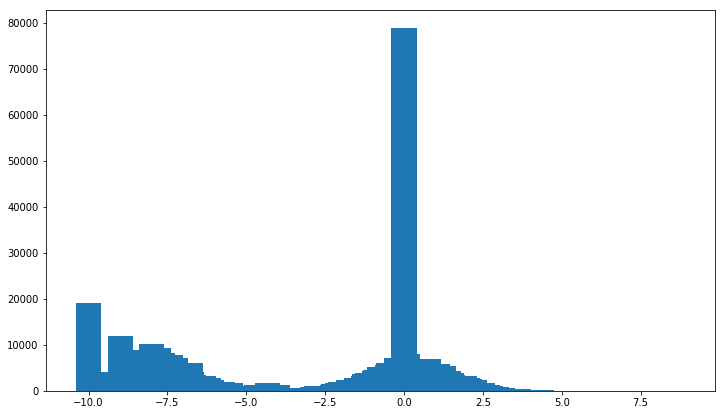

In [9]:
#0s are not inserted scores
plt.figure(figsize=(12, 7))
w = collections.Counter(animelists["my_score"])
plt.bar(w.keys(), w.values())
#plt.grid()
plt.show()

##### Users Days spent watching Distribution

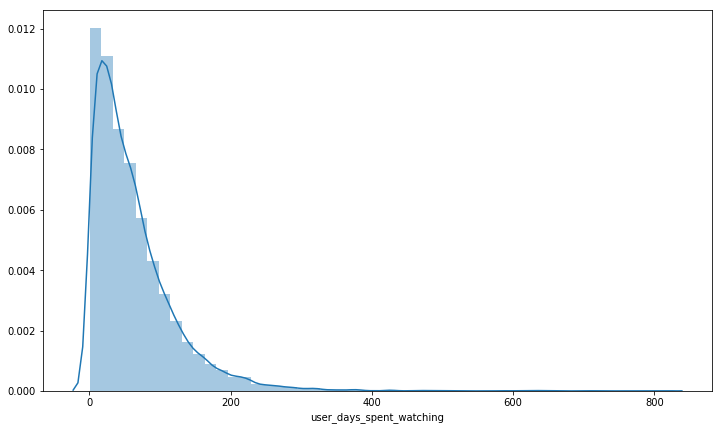

In [10]:
plt.figure(figsize=(12, 7))
days=users["user_days_spent_watching"]
sns.distplot(days)
plt.show()

##### Scatterplot Anime users/score

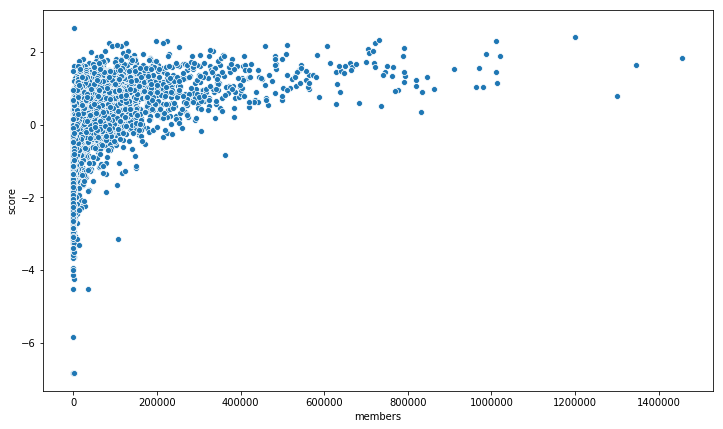

In [11]:
n_users = anime["members"]
mean_score = anime["score"]
plt.figure(figsize=(12, 7))
sns.scatterplot(n_users,mean_score)
plt.show()

##### Genre Bar Plot

In [12]:
genres=anime["genre"]
genres = genres[~genres.isnull()] #remove nulls (num=4)
l=[]
for n in genres.index.values:
        data=genres[n].split(', ')
        l.extend(data)
        
count_g = collections.Counter(l)
g_names=count_g
print(g_names)

Counter({'Comedy': 3021, 'Action': 2051, 'Fantasy': 1441, 'Adventure': 1355, 'Drama': 1338, 'Sci-Fi': 1318, 'Shounen': 1182, 'Romance': 1177, 'School': 1004, 'Slice of Life': 927, 'Supernatural': 860, 'Magic': 604, 'Mecha': 543, 'Ecchi': 506, 'Seinen': 470, 'Mystery': 454, 'Shoujo': 440, 'Historical': 425, 'Kids': 406, 'Super Power': 367, 'Sports': 338, 'Hentai': 331, 'Music': 329, 'Military': 312, 'Harem': 276, 'Parody': 267, 'Space': 247, 'Horror': 227, 'Demons': 223, 'Psychological': 206, 'Martial Arts': 193, 'Game': 168, 'Police': 155, 'Samurai': 102, 'Vampire': 100, 'Thriller': 79, 'Josei': 67, 'Shoujo Ai': 56, 'Shounen Ai': 55, 'Dementia': 47, 'Cars': 41, 'Yaoi': 28, 'Yuri': 10})


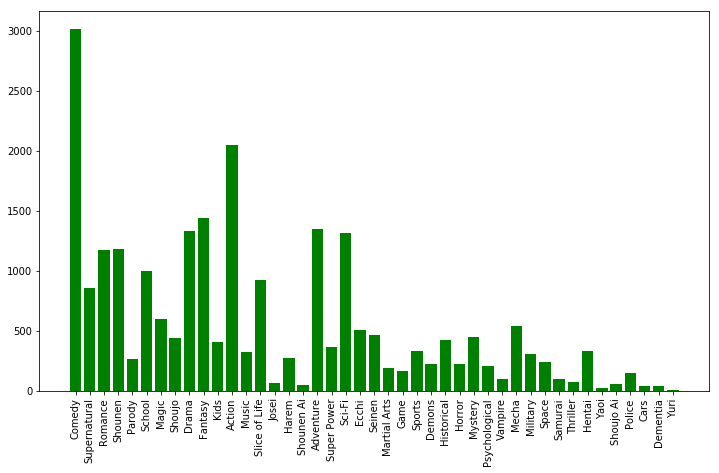

In [13]:
plt.figure(figsize=(12, 7))
plt.bar(count_g.keys(), count_g.values(),align='center',color="green")
plt.xticks(rotation=90)
plt.show()

### Content Based Recommendation

##### Data Preprocessing

In [14]:
content_based = pd.concat([anime[["anime_id"]],anime[["score"]],anime[["aired_from_year"]],anime[["members"]],pd.get_dummies(anime[["type"]]),pd.get_dummies(anime[["rating"]]),anime["episodes"], anime["genre"].str.get_dummies(sep=", ")],axis=1)
display(content_based.head())

anime_id     score  aired_from_year  members  type_Movie  type_Music  \
0     11013  0.781002           2012.0   283882           0           0   
1      2104  1.041002           2007.0   204003           0           0   
2      5262  0.701002           2008.0    70127           0           0   
3       721  1.361002           2002.0    93312           0           0   
4     12365  1.821002           2012.0   182765           0           0   

   type_ONA  type_OVA  type_Special  type_TV  rating_G - All Ages  \
0         0         0             0        1                    0   
1         0         0             0        1                    0   
2         0         0             0        1                    0   
3         0         0             0        1                    0   
4         0         0             0        1                    0   

   rating_None  rating_PG - Children  rating_PG-13 - Teens 13 or older  \
0            0                     0                                 1   
1            0                     0                                 1   
2            0                     1                                 0   
3            0                     0                                 1   
4            0                     0                                 1   

   rating_R - 17+ (violence & profanity)  rating_R+ - Mild Nudity  \
0                                      0                        0   
1                                      0                        0   
2                                      0                        0   
3                                      0                        0   
4                                      0                        0   

   rating_Rx - Hentai  episodes  Action  Adventure  Cars  Comedy  Dementia  \
0                   0        12       0          0     0       1         0   
1                   0        26       0          0     0       1         0   
2                   0        51       0          0     0       1         0   
3                   0        38       0          0     0       1         0   
4                   0        25       0          0     0       1         0   

   Demons  Drama  Ecchi  Fantasy  Game  Harem  Hentai  Historical  Horror  \
0       0      0      0        0     0      0       0           0       0   
1       0      0      0        0     0      0       0           0       0   
2       0      0      0        0     0      0       0           0       0   
3       0      1      0        1     0      0       0           0       0   
4       0      1      0        0     0      0       0           0       0   

   Josei  Kids  Magic  Martial Arts  Mecha  Military  Music  Mystery  Parody  \
0      0     0      0             0      0         0      0        0       0   
1      0     0      0             0      0         0      0        0       1   
2      0     0      1             0      0         0      0        0       0   
3      0     0      1             0      0         0      0        0       0   
4      0     0      0             0      0         0      0        0       0   

   Police  Psychological  Romance  Samurai  School  Sci-Fi  Seinen  Shoujo  \
0       0              0        1        0       0       0       0       0   
1       0              0        1        0       1       0       0       0   
2       0              0        0        0       1       0       0       1   
3       0              0        1        0       0       0       0       0   
4       0              0        1        0       0       0       0       0   

   Shoujo Ai  Shounen  Shounen Ai  Slice of Life  Space  Sports  Super Power  \
0          0        1           0              0      0       0            0   
1          0        1           0              0      0       0            0   
2          0        0           0              0      0       0            0   
3          0        0           0              0      0       0            

In [15]:
print(content_based.isnull().sum())
content_based = content_based[~content_based.isnull()] #drop anime that have NaN

anime_id                                 0
score                                    0
aired_from_year                          0
members                                  0
type_Movie                               0
type_Music                               0
type_ONA                                 0
type_OVA                                 0
type_Special                             0
type_TV                                  0
rating_G - All Ages                      0
rating_None                              0
rating_PG - Children                     0
rating_PG-13 - Teens 13 or older         0
rating_R - 17+ (violence & profanity)    0
rating_R+ - Mild Nudity                  0
rating_Rx - Hentai                       0
episodes                                 0
Action                                   0
Adventure                                0
Cars                                     0
Comedy                                   0
Dementia                                 0
Demons     

In [16]:
from sklearn.preprocessing import MaxAbsScaler
max_abs_scaler = MaxAbsScaler()
content_based.iloc[:,1:] = max_abs_scaler.fit_transform(content_based.iloc[:,1:])

In [17]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(content_based.iloc[:,1:])
distances, indices = nbrs.kneighbors(content_based.iloc[:,1:])

In [18]:
indices[17]

array([  17, 2199,  481,  106, 3794])

In [19]:
#Change url to one that works
print("This link works","https://cdn.myanimelist.net/"+anime["image_url"][0][33:])
print("This does not",anime["image_url"][0])
anime["image_url"] = anime["image_url"].replace({'https://myanimelist.cdn-dena.com':'https://cdn.myanimelist.net'}, regex=True)

This link works https://cdn.myanimelist.net/images/anime/12/35893.jpg
This does not https://myanimelist.cdn-dena.com/images/anime/12/35893.jpg


In [20]:
anime[["title","anime_id","image_url"]][:10]

title  anime_id  \
0                  Inu x Boku SS     11013   
1               Seto no Hanayome      2104   
2             Shugo Chara!! Doki      5262   
3                  Princess Tutu       721   
4            Bakuman. 3rd Season     12365   
5            Yume-iro Pâtissière      6586   
6                   Ultra Maniac       178   
7  Shakugan no Shana II (Second)      2787   
8    Nodame Cantabile: Paris-hen      4477   
9         Ouran Koukou Host Club       853   

                                           image_url  
0  https://cdn.myanimelist.net/images/anime/12/35...  
1  https://cdn.myanimelist.net/images/anime/13/58...  
2  https://cdn.myanimelist.net/images/anime/11/10...  
3  https://cdn.myanimelist.net/images/anime/13/32...  
4  https://cdn.myanimelist.net/images/anime/6/418...  
5  https://cdn.myanimelist.net/images/anime/12/21...  
6  https://cdn.myanimelist.net/images/anime/8/535...  
7  https://cdn.myanimelist.net/images/anime/10/18...  
8  https://cdn.myanimelist.net/images/anime/4/119...  
9  https://cdn.myanimelist.net/images/anime/2/719...

In [21]:
save_obj(anime[["title","anime_id","image_url"]],"anime_info")

In [22]:
def content_recs(indices):
    fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(22,5))
    title=[]
    for i in range(len(indices)):
        n=indices[i]
        url=anime["image_url"][n]
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        ax[i].imshow(img)
        ax[i].axis('off')
    display(anime.loc[ indices , ['anime_id', 'title','genre','type','rating','members','episodes'] ])
    plt.show()

anime_id                            title  \
2199        20                           Naruto   
17        1735               Naruto: Shippuuden   
481        813                    Dragon Ball Z   
106      30694                Dragon Ball Super   
2414     34566  Boruto: Naruto Next Generations   

                                                  genre type  \
2199  Action, Adventure, Comedy, Super Power, Martia...   TV   
17    Action, Adventure, Comedy, Super Power, Martia...   TV   
481   Action, Adventure, Comedy, Fantasy, Martial Ar...   TV   
106   Action, Adventure, Comedy, Fantasy, Martial Ar...   TV   
2414  Action, Adventure, Martial Arts, Shounen, Supe...   TV   

                         rating  members  episodes  
2199  PG-13 - Teens 13 or older   980265       220  
17    PG-13 - Teens 13 or older   794112       500  
481   PG-13 - Teens 13 or older   534974       291  
106   PG-13 - Teens 13 or older   250101       131  
2414  PG-13 - Teens 13 or older   213675         0

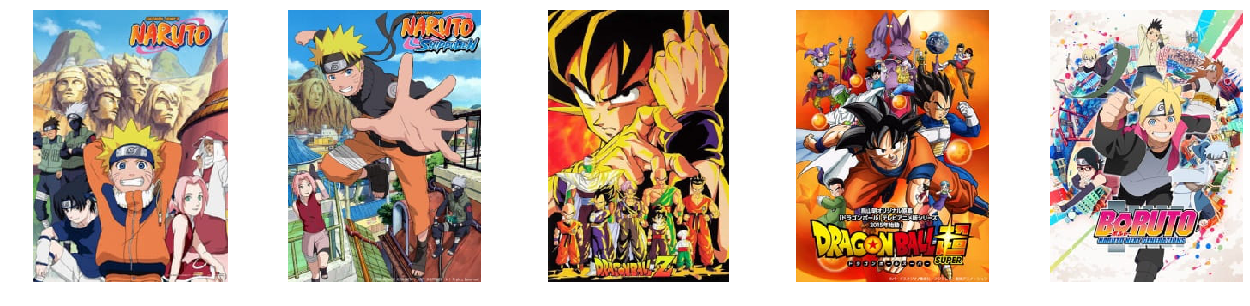

In [23]:
num=2199
content_recs(indices[num])

anime_id                                              title  \
1350       895  Dragon Ball Z Movie 02: Kono Yo de Ichiban Tsu...   
2246       894    Dragon Ball Z Movie 01: Ora no Gohan wo Kaese!!   
5255       896  Dragon Ball Z Movie 03: Chikyuu Marugoto Chouk...   
6166       899  Dragon Ball Z Movie 06: Gekitotsu!! 100-oku Po...   
5610       900  Dragon Ball Z Movie 07: Kyokugen Battle!! Sand...   

                                                  genre   type  \
1350  Action, Sci-Fi, Adventure, Comedy, Fantasy, Sh...  Movie   
2246  Action, Sci-Fi, Adventure, Comedy, Fantasy, Sh...  Movie   
5255  Action, Sci-Fi, Adventure, Comedy, Fantasy, Sh...  Movie   
6166  Action, Sci-Fi, Adventure, Comedy, Fantasy, Sh...  Movie   
5610  Action, Sci-Fi, Adventure, Comedy, Fantasy, Sh...  Movie   

                         rating  members  episodes  
1350  PG-13 - Teens 13 or older    65967         1  
2246  PG-13 - Teens 13 or older    71222         1  
5255  PG-13 - Teens 13 or older    72815         1  
6166  PG-13 - Teens 13 or older    70798         1  
5610  PG-13 - Teens 13 or older    66662         1

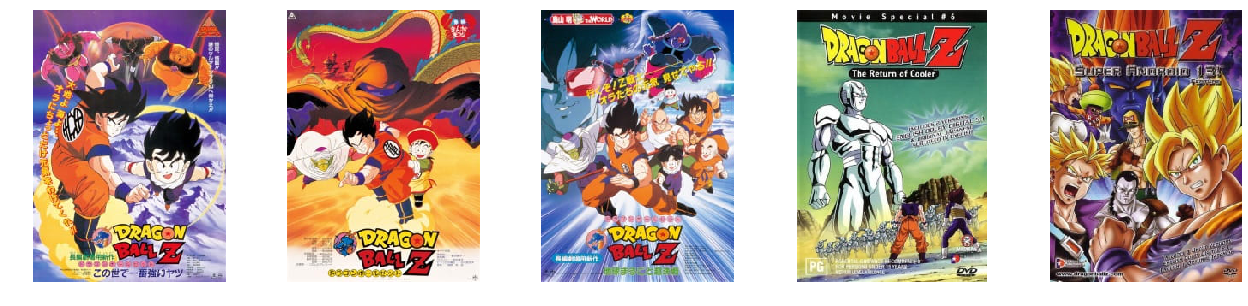

In [24]:
num=1350
content_recs(indices[num])

anime_id                             title  \
5710     31964             Boku no Hero Academia   
2048     33486  Boku no Hero Academia 2nd Season   
5468     36456  Boku no Hero Academia 3rd Season   
488      24833                Ansatsu Kyoushitsu   
3828     30654     Ansatsu Kyoushitsu 2nd Season   

                                             genre type  \
5710  Action, Comedy, School, Shounen, Super Power   TV   
2048  Action, Comedy, Super Power, School, Shounen   TV   
5468  Action, Comedy, School, Shounen, Super Power   TV   
488                Action, Comedy, School, Shounen   TV   
3828               Action, Comedy, School, Shounen   TV   

                         rating  members  episodes  
5710  PG-13 - Teens 13 or older   763973        13  
2048  PG-13 - Teens 13 or older   583016        25  
5468  PG-13 - Teens 13 or older   282743        25  
488   PG-13 - Teens 13 or older   574476        22  
3828  PG-13 - Teens 13 or older   380565        25

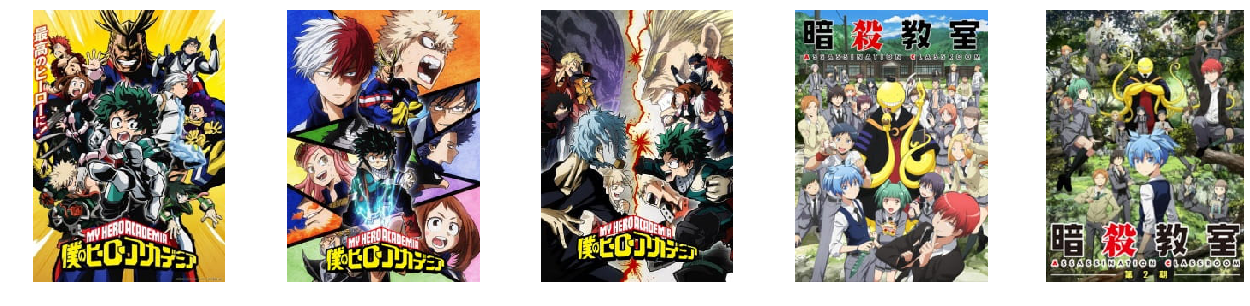

In [25]:
num=5710
content_recs(indices[num])

### Collaborative Recommendation

##### Data Preprocessing

In [26]:
anime.head(1)

anime_id          title              title_english title_japanese  \
0     11013  Inu x Boku SS  Inu X Boku Secret Service         妖狐×僕SS   

    title_synonyms                                          image_url type  \
0  Youko x Boku SS  https://cdn.myanimelist.net/images/anime/12/35...   TV   

  source  episodes           status  airing                  aired_string  \
0  Manga        12  Finished Airing   False  Jan 13, 2012 to Mar 30, 2012   

                                        aired         duration  \
0  {'from': '2012-01-13', 'to': '2012-03-30'}  24 min. per ep.   

                      rating     score  scored_by    rank  popularity  \
0  PG-13 - Teens 13 or older  0.781002     139250  1274.0         231   

   members  favorites                                         background  \
0   283882       2809  Inu x Boku SS was licensed by Sentai Filmworks...   

     premiered           broadcast  \
0  Winter 2012  Fridays at Unknown   

                                             related  \
0  {'Adaptation': [{'mal_id': 17207, 'type': 'man...   

                                            producer          licensor  \
0  Aniplex, Square Enix, Mainichi Broadcasting Sy...  Sentai Filmworks   

             studio                                   genre  \
0  David Production  Comedy, Supernatural, Romance, Shounen   

           opening_theme                                       ending_theme  \
0  ['"Nirvana" by MUCC']  ['#1: "Nirvana" by MUCC (eps 1, 11-12)', '#2: ...   

   duration_min  aired_from_year  
0          24.0           2012.0

In [27]:
animelists.head(1)

username  anime_id  my_watched_episodes  my_score  my_status
0  Akihara        21                  835      1.54          1

In [28]:
animean = pd.merge(users[["username","stats_mean_score","user_id"]],animelists[["username","anime_id","my_score","my_status"]],on=['username','username'])
display(animean.head())

username  stats_mean_score  user_id  anime_id  my_score  my_status
0  Zapiboss              8.24   332184        21      0.76          1
1  Zapiboss              8.24   332184       120     -8.24          6
2  Zapiboss              8.24   332184       178     -8.24          6
3  Zapiboss              8.24   332184       269     -0.24          3
4  Zapiboss              8.24   332184       853     -0.24          2

In [29]:
combined_data = pd.merge(anime[["anime_id","title"]], animean[["user_id","username","anime_id","my_score"]], on=['anime_id', 'anime_id'])
combined_data.head(10)

anime_id          title  user_id          username  my_score
0     11013  Inu x Boku SS   332184          Zapiboss      0.76
1     11013  Inu x Boku SS  3672201           solar20     -9.48
2     11013  Inu x Boku SS  2661243         NBMKnives     -8.47
3     11013  Inu x Boku SS  2359855   WhisperingNight     -7.58
4     11013  Inu x Boku SS  4600326  PrincessAutistic     -8.44
5     11013  Inu x Boku SS  2027273     ShizukuSangou     -8.58
6     11013  Inu x Boku SS  4650177       Rebelshadow      0.09
7     11013  Inu x Boku SS  1110147     Himura_Kamina      0.04
8     11013  Inu x Boku SS  2326099          Joworaka     -8.25
9     11013  Inu x Boku SS   110529          -pixxie-     -8.05

In [30]:
user_anime = pd.crosstab(combined_data['username'], combined_data['anime_id'],values=combined_data['my_score'],aggfunc='mean')
user_anime=user_anime.fillna(0)
user_anime.head()

anime_id          1      5      6      7      8      15     16     17     \
username                                                                   
---L-AND-AME-4EV   0.00   0.00   0.00    0.0    0.0    0.0   0.00    0.0   
--yukii            0.00   0.00   0.00    0.0    0.0    0.0   0.00    0.0   
-Aine-             0.00   0.00   0.00    0.0    0.0    0.0   0.00    0.0   
-Belatriz-         0.00   0.00   0.00    0.0    0.0    0.0   1.01    0.0   
-BlackRabbit-      3.13   1.13   1.13    0.0    0.0    0.0   0.00    0.0   

anime_id          18     19     20     21     22     23     24     25     \
username                                                                   
---L-AND-AME-4EV    0.0    0.0  -1.00   0.00    0.0    0.0   0.00    0.0   
--yukii             0.0    0.0  -1.62   0.00    0.0    0.0   0.00    0.0   
-Aine-              0.0    0.0   0.00  -1.75    0.0    0.0   0.00    0.0   
-Belatriz-          0.0    0.0  -0.99   0.00    0.0    0.0   1.01    0.0   
-BlackRabbit-       0.0    0.0  -0.87  -2.87    0.0    0.0   0.00    0.0   

anime_id          26     27     28     29     30     31     32     33     \
username                                                                   
---L-AND-AME-4EV    0.0    0.0    0.0    0.0   0.00    0.0    0.0   0.00   
--yukii             0.0    0.0    0.0    0.0   0.00    0.0    0.0   0.00   
-Aine-              0.0    0.0    0.0    0.0  -7.75    0.0    0.0   0.00   
-Belatriz-          0.0    0.0    0.0    0.0   0.00    0.0    0.0   0.00   
-BlackRabbit-       0.0    0.0    0.0    0.0   3.13    0.0    0.0   2.13   

anime_id          43     44     45     46     47     48     49     50     \
username                                                                   
---L-AND-AME-4EV   0.00    0.0    0.0    0.0   0.00    0.0    0.0    0.0   
--yukii            0.00    0.0    0.0    0.0   0.00    0.0    0.0    0.0   
-Aine-             0.00    0.0    0.0    0.0   0.00    0.0    0.0    0.0   
-Belatriz-         0.00    0.0    0.0    0.0   0.00    0.0    0.0    0.0   
-BlackRabbit-      3.13    0.0    0.0    0.0   0.13    0.0    0.0    0.0   

anime_id          51     52     53     54     55     56     57     58     \
username                                                                   
---L-AND-AME-4EV    0.0   0.00    0.0   0.00    0.0    0.0   0.00    0.0   
--yukii             0.0   0.00    0.0   0.00    0.0    0.0   0.00    0.0   
-Aine-              0.0  -7.75    0.0   0.00    0.0    0.0   0.00    0.0   
-Belatriz-          0.0  -7.99    0.0   0.00    0.0    0.0   1.01    0.0   
-BlackRabbit-       0.0   0.00    0.0   1.13    0.0    0.0  -2.87    0.0   

anime_id          59     60     61     62     63     64     65     66     \
username                                                                   
---L-AND-AME-4EV   0.00   0.00   0.00   0.00    0.0   0.00   0.00    0.0   
--yukii            0.00   0.00   0.00   0.00    0.0  -9.62   0.00    0.0   
-Aine-            -7.75   0.00   2.25   0.00    0.0   2.25   2.25    0.0   
-Belatriz-        -0.99   0.00   0.00  -7.99    0.0   0.00   0.00    0.0   
-BlackRabbit-      0.00   0.13   0.00   0.00    0.0   0.00   0.00    0.0   

anime_id          67     68     69     71     72     73     74     75     \
username                                                                   
---L-AND-AME-4EV    0.0    0.0    0.0   0.00   0.00   0.00   0.00    0.0   
--yukii             0.0    0.0    0.0  -9.62   0.00   0.00   0.38    0.0   
-Aine-              0.0    0.0    0.0   0.00   0.00   0.00   0.00    0.0   
-Belatriz-          0.0    0.0    0.0   0.01   0.01   0.01   0.00    0.0   
-BlackRabbit-       0.0    0.0    0.0   0.00   0.00   0.00   0.00    0.0   

anime_id          76     77     79     80     81     82     83     84     \
username                                                                   
---L-AND-AME-4EV   0.00   0.00   0.00    0.0    0.0    0.0    0.0    0.0   
--yukii            0.38  -9.62   0.00    

In [31]:
save_obj(user_anime,"user_anime")

In [32]:
user_table=pd.concat([users[["username"]],users[["user_id"]],pd.get_dummies(users[["gender"]]),users[["stats_mean_score"]],users["stats_episodes"]],axis=1)
user_table= pd.merge(user_table,user_anime ,on=['username', 'username'])
user_table.head()

username  user_id  gender_Female  gender_Male  gender_Non-Binary  \
0       Zapiboss   332184              0            1                  0   
1  CinnamonBunny   285543              1            0                  0   
2        mufadol  2708355              0            1                  0   
3    Lumisateita   395521              1            0                  0   
4        K3ik0ku   522057              0            1                  0   

   stats_mean_score  stats_episodes     1     5     6    7    8    15    16  \
0              8.24           12512  0.00  0.00  0.00  0.0  0.0  0.76  0.00   
1              8.86            3830  0.00  0.00  0.00  0.0  0.0  1.14 -4.86   
2              9.00              91  0.00  0.00  0.00  0.0  0.0  0.00  0.00   
3              6.92            1792  2.08  1.08  0.08  0.0  0.0  0.00  0.00   
4              0.00            4335  0.00  0.00  0.00  0.0  0.0  0.00  0.00   

    17   18    19    20    21   22   23    24   25   26    27   28   29   30  \
0  0.0  0.0  1.76  0.76  0.76  0.0  0.0 -3.24  0.0  0.0  0.00  0.0  0.0  0.0   
1  0.0  0.0  0.00  0.14  0.00  0.0  0.0  0.00  0.0  0.0  1.14  0.0  0.0  0.0   
2  0.0  0.0  0.00  0.00  0.00  0.0  0.0  0.00  0.0  0.0  0.00  0.0  0.0  0.0   
3  0.0  0.0  0.00 -0.92  0.00  0.0  0.0  0.00  0.0  0.0  0.00  0.0  0.0  0.0   
4  0.0  0.0  0.00  0.00  0.00  0.0  0.0  0.00  0.0  0.0  0.00  0.0  0.0  0.0   

    31   32   33    43   44    45   46    47    48   49    50    51   52  \
0  0.0  0.0  0.0  0.00  0.0  0.00  0.0 -0.24 -8.24  0.0 -8.24  0.00  0.0   
1  0.0  0.0  0.0  0.00  0.0  1.14  0.0  0.00 -2.86  0.0  0.00  0.00  0.0   
2  0.0  0.0  0.0  0.00  0.0  0.00  0.0  0.00  0.00  0.0  0.00  0.00  0.0   
3  0.0  0.0  0.0  2.08  0.0  0.00  0.0  0.00  0.00  0.0  0.00 -2.92  0.0   
4  0.0  0.0  0.0  0.00  0.0  0.00  0.0  0.00  0.00  0.0  0.00  0.00  0.0   

     53    54   55   56   57   58   59    60    61    62    63   64   65  \
0 -8.24  0.00  0.0  0.0  0.0  0.0  0.0  0.76  0.00 -1.24 -8.24  0.0  0.0   
1  0.00  0.00  0.0  0.0  0.0  0.0  0.0 -8.86 -8.86  0.00  0.00  0.0  0.0   
2  0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.00  0.00  0.0  0.0   
3  0.00  0.08  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.00  0.00  0.0  0.0   
4  0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.00  0.00  0.0  0.0   

     66   67    68    69    71    72    73   74    75   76   77    79   80  \
0  0.00  0.0  0.76 -8.24  0.76 -8.24  0.76  0.0  0.76  0.0  0.0  0.76  0.0   
1 -8.86  0.0 -8.86  0.00 -8.86  0.00  0.00  0.0  0.00  0.0  0.0  0.00  0.0   
2  0.00  0.0  0.00  0.00  0.00  0.00  0.00  0.0  0.00  0.0  0.0  0.00  0.0   
3  0.00  0.0  0.00  0.00  0.00  0.00  0.00  0.0  0.00  0.0  0.0  0.00  0.0   
4  0.00  0.0  0.00  0.00  0.00  0.00  0.00  0.0  0.00  0.0  0.0  0.00  0.0   

    81   82   83   84   85   86   87   89   90   91   92    93   94   95   96  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.24  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.14  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.0  0.0  0.0   

    97   98   99  100   101   102  103  104  105   106  107  109  110  111  \
0  0.0  0.0  0.0  0.0  0.76 -8.24  0.0  0.0  0.0  0.00  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.00  0.00  0.0  0.0  0.0 -1.86  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.00  0.00  0.0  0.0  0.0  0.00  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.00  0.00  0.0  0.0  0.0  0.00  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.00  0.00  0.0  0.0  0.0  0.00  0.0  0.0  0.0  0.0   

   112  113  114  115  116  117  118   119   120   121   122  123  124   125  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -8.24 -8.24  0.76  0.00  0.0  0.0 -1.24   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00  1.14  1.14 -8.86  0.0  0.0  0.00   
2  0.0  0.0  0.0

##### Analyze datset

In [33]:
def fun_pca(inp,dim): #Dimensionality reduction to reduce computation cost
    if dim==3:
        pca = PCA(n_components=3)
    elif dim==2:
        pca = PCA(n_components=2)
    else:
        pca = PCA(n_components=dim)
        
    pca.fit(inp)
    pca_samples = pca.transform(inp)
    ps = pd.DataFrame(pca_samples)
    ps.head()
    output = pd.DataFrame(ps[list(range(dim))])
    
    if dim==3:
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(output[0], output[2], output[1])
        plt.title('3D PCA', fontsize=20)
        
    if dim==2:
        fig = plt.figure()
        sns.scatterplot(output[0], output[1])
        plt.title('2D PCA', fontsize=20)
    
        plt.show()
    return output

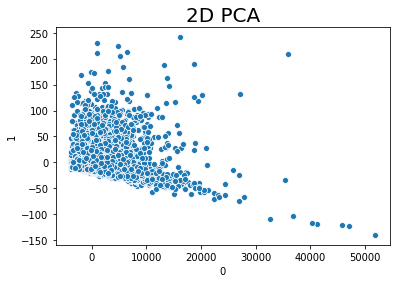

In [34]:
dim=2
after_pca=fun_pca(user_table.iloc[:,2:],dim)

##### Kmeans Clustering

In [35]:
def fun_kmeans(inp,seed):
    clusters = KMeans(n_clusters=5,random_state=seed).fit(inp)
    centers = clusters.cluster_centers_
    predictions= clusters.predict(inp)
    return centers,predictions

In [36]:
centers,predictions=fun_kmeans(after_pca,seed)

In [37]:
predictions[:10]

array([1, 0, 2, 2, 0, 2, 0, 4, 0, 1], dtype=int32)

In [38]:
a=user_table.iloc[0,2:].values
b=user_table.iloc[6,2:].values
an=dot(a, b)/(norm(a)*norm(b))
display(an)

0.9997008383443577

In [39]:
def fun_plot_kmeans(after_pca,predictions,dim):
    if dim==2:
        plt.scatter(after_pca[0], after_pca[1], c = predictions)
    elif dim==3:
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(after_pca[0],after_pca[2], after_pca[1], c = predictions)
    plt.show()

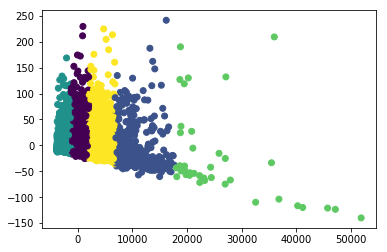

In [40]:
fun_plot_kmeans(after_pca,predictions,dim)

##### Predictions using LightFM

In [41]:
dict_anime = {}
combined_data = combined_data.sort_values('anime_id')
i=0
for title,anime_id in zip(combined_data['title'].unique(),combined_data['anime_id'].unique()):
    dict_anime[i] = [anime_id,title]
    i+=1

dict_user = {}
combined_data = combined_data.sort_values('user_id')
i=0
for username,user_id in zip(combined_data['username'].unique(),combined_data['user_id'].unique()):
    dict_user[i] = username
    i+=1

In [42]:
save_obj(dict_anime,"dict_anime")
save_obj(dict_user,"dict_user")

In [43]:
crosstab_mat = sparse.coo_matrix(user_anime)

In [44]:
save_obj(crosstab_mat,"crosstab")

In [45]:
model = LightFM(loss='warp')
%time model.fit(crosstab_mat, epochs=30, num_threads=20)

CPU times: user 1min 50s, sys: 46.1 s, total: 2min 36s
Wall time: 24.8 s


In [46]:
print("Train precision: %.2f" % precision_at_k(model, crosstab_mat, k=5).mean())

Train precision: 0.81


In [47]:
save_obj(model, "model")

##### Useful Resources
https://www.kaggle.com/martelloti/myanimelist-recommender-system

https://github.com/tuvtran/AniRec/blob/master/Anime-Recommendation.ipynb